In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
from statsmodels.tsa.stattools import adfuller

# Recursive OLS residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import chow_test

import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

In [111]:
inf1 = pd.read_csv('data/inflation.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date, format='%d/%m/%Y')
inf1 = inf1.drop("date", axis = 1)
inf1['v_cpi'] = inf1['CPI'].pct_change(12)*100
inf1['vol_cpi1'] = inf1['CPI'].rolling(12).std()
# inf1.head()

In [112]:
simdf = inf1.loc['1993-01-01':'2021-12-01']
predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

<AxesSubplot:xlabel='date'>

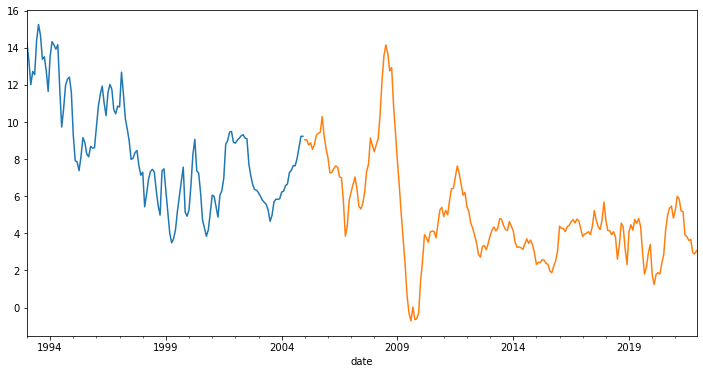

In [113]:
predf['v_cpi'].plot(figsize=(12,6))
itdf['v_cpi'].plot(figsize=(12,6))

In [114]:
# ADF Test for Stationarity on inflation

# Whole period
adf = adfuller(simdf['v_cpi'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['v_cpi'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['v_cpi'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.03841611734408168 , whole period: Series is Stationary
p value:0.15320315266553963 , Series is Non-Stationary
p value:0.19635563540377454 , Series is Non-Stationary


Aditive Decomposition for Inflation

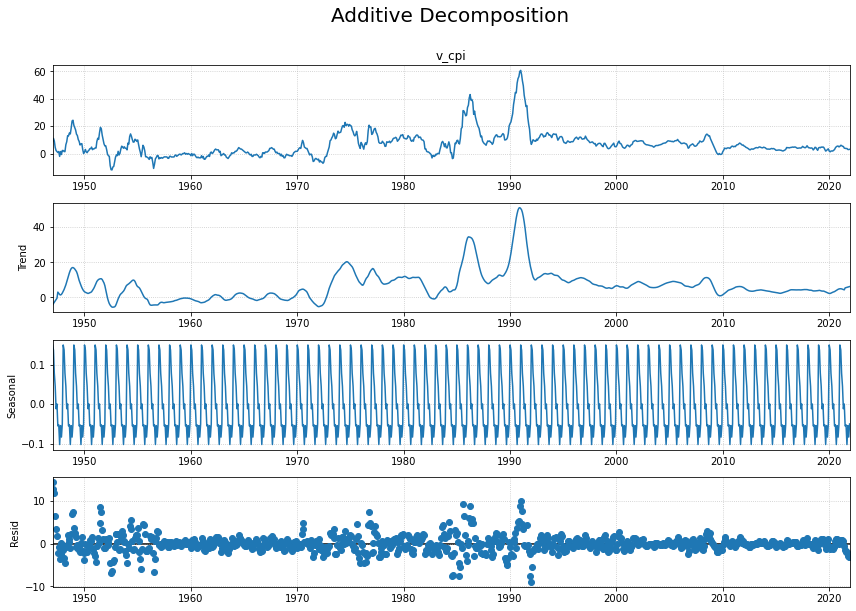

In [115]:
# # Additive Decomposition
plt.rcParams['figure.figsize'] = (12, 8);
a = tsa.seasonal_decompose(inf1['v_cpi'][12:],model='additive', extrapolate_trend='freq').plot()
plt.suptitle('Additive Decomposition', x = 0.525, y = 1.055, fontsize=20)
for i in range(len(a.axes)):
    a.axes[i].grid(axis='x', alpha=0.75, linestyle=':')
    a.axes[i].grid(axis='y', alpha=0.75, linestyle=':')
plt.show()

In [116]:
decomp = tsa.seasonal_decompose(inf1['v_cpi'][12:],model='additive', extrapolate_trend='freq')
df_rec = pd.concat([decomp.seasonal, decomp.trend, decomp.resid, decomp.observed], axis=1)
df_rec.columns = ['seas', 'trend', 'resid', 'actual_values']
df_rec.head()

,seas,trend,resid,actual_values
date,,,,
1947-01-01,0.149721,-4.176101,12.687797,8.661417
1947-02-01,0.136805,-3.423370,14.310186,11.023622
1947-03-01,0.078374,-2.670638,11.752570,9.160305
1947-04-01,0.045319,-1.917907,6.350199,4.477612
1947-05-01,-0.011785,-1.165175,3.366741,2.189781


In [117]:
# DataFrame with seasonally adjusted Data
inf1['inf_seasAdj'] = df_rec.resid

# IT regime dummy variable
inf1['IT_reg'] = np.zeros(len(inf1))
inf1['IT_reg']['2005-01-01':] = 1 

# lag creation
inf1["inf_seasAdj_l1"] = inf1['inf_seasAdj'].shift()
inf1["inf_seasAdj_l3"] = inf1['inf_seasAdj'].shift(3)
inf1["inf_seasAdj_l6"] = inf1['inf_seasAdj'].shift(6)
inf1["inf_seasAdj_l12"] = inf1['inf_seasAdj'].shift(12)
inf1["inf_seasAdj_l24"] = inf1['inf_seasAdj'].shift(24)
# drop na's
inf1.dropna(inplace=True)

# Working DataFrames
# complete "simetric" dataframe
simdf = inf1.loc['1993-01-01':'2021-12-01']
# Pre IT DataFrame
predf = simdf.loc['1993-01-01':'2004-12-01']
# IT DataFrame
itdf  = simdf.loc['2005-01-01':'2021-12-01']


In [232]:
# DataFrame with observed data
''' This data is for the models and tests which consider the whole period, since v_cpi is stationary when we consider 
the whole period. '''
inf2 = pd.read_csv('data/inflation.csv', delimiter=';')
inf2.index = pd.to_datetime(inf2.date, format='%d/%m/%Y')
inf2 = inf2.drop("date", axis = 1)
inf2['v_cpi'] = inf2['CPI'].pct_change(12)*100

# IT regime dummy variable
inf2['IT_reg'] = np.zeros(len(inf2))
inf2['IT_reg']['2005-01-01':] = 1 

# lag creation
inf2["l1"] = inf2['v_cpi'].shift()
inf2["l3"] = inf2['v_cpi'].shift(3)
inf2["l6"] = inf2['v_cpi'].shift(6)
inf2["l12"] = inf2['v_cpi'].shift(12)
inf2["l18"] = inf2['v_cpi'].shift(18)
inf2["l24"] = inf2['v_cpi'].shift(24)
# drop na's
inf2.dropna(inplace=True)

# Working DataFrames
# complete "simetric" dataframe
simdf2 = inf2.loc['1993-01-01':'2021-12-01']
# Pre IT DataFrame
predf2 = inf2.loc['1993-01-01':'2004-12-01']
# IT DataFrame
itdf2  = inf2.loc['2005-01-01':'2021-12-01']

# inf2.head(24)

In [233]:
inf1.to_csv('output/inflation_SeasAdj.csv', sep=';')
inf2.to_csv('output/inflationLags.csv', sep=';')

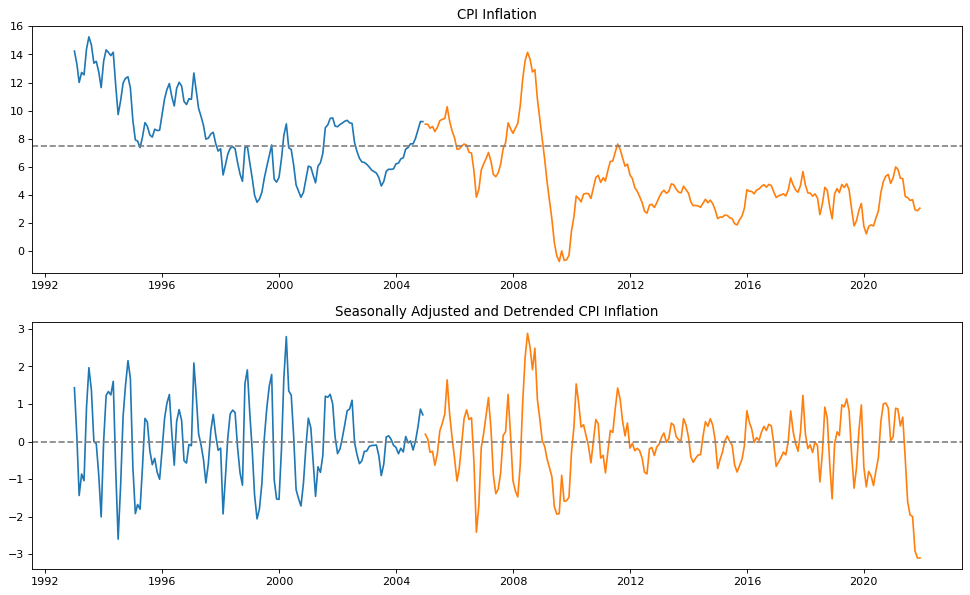

In [237]:
# Ploting the data
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi= 80)

axes[0].plot(predf['v_cpi'])
axes[0].plot(itdf['v_cpi'])
axes[0].set_title('CPI Inflation')
axes[0].axhline(y=np.mean(inf1['v_cpi']), color='grey', linestyle='--')

axes[1].plot(predf['inf_seasAdj'])
axes[1].plot(itdf['inf_seasAdj'])
axes[1].set_title('Seasonally Adjusted and Detrended CPI Inflation')
axes[1].axhline(y=0, color='grey', linestyle='--')

plt.show()


In [120]:
# ADF Test for Stationarity on Seasonally adjusted inflation
# Whole period
adf = adfuller(simdf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:1.870370093513673e-09 , whole period: Series is Stationary
p value:5.359212083582485e-05 , Pre IT period: Series is Stationary
p value:0.003422291791936745 , IT period: Series is Stationary


Benchmark Models

Kontonikas (2004)

$\pi = \gamma_0 + \gamma_1\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + \gamma_4\pi_{t-12} + u_{1t}$

Model 1: Using the seasonally adjusted data

In [121]:
# Whole Period
mod1_1 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6 + inf_seasAdj_l12', data=simdf).fit() #+ inf_seasAdj_l3 + inf_seasAdj_l6
print(mod1_1.params)
print('Estimated persistence, Complete period: ',mod1_1.params.sum())

Intercept         -0.030400
inf_seasAdj_l1     0.706229
inf_seasAdj_l3    -0.258603
inf_seasAdj_l6     0.113868
inf_seasAdj_l12   -0.182637
dtype: float64
Estimated persistence, Complete period:  0.34845633047388025


In [ ]:
mod1_1.pvalues
# All lags significant

Intercept          3.343030e-01
inf_seasAdj_l1     2.992466e-49
inf_seasAdj_l3     3.100467e-12
inf_seasAdj_l6     2.514321e-03
inf_seasAdj_l12    1.013216e-07
dtype: float64

In [136]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres = recursive_olsresiduals(mod1_1, alpha=0.90)

breaks_cusumolsresid(mod1_1.resid)
# We cannot reject the null hypothesis of no structural change.

(0.729043908894949, 0.6624986464217185, [(1, 1.63), (5, 1.36), (10, 1.22)])

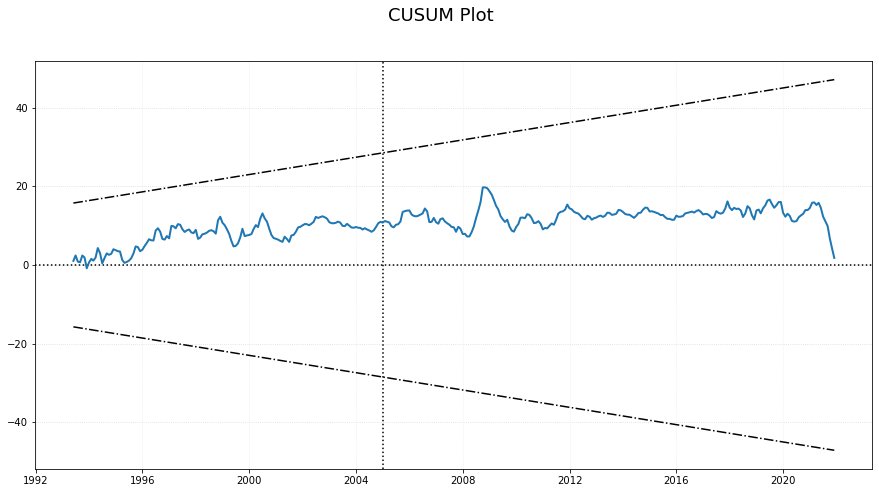

In [133]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres[6][1],index=simdf.index[5:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres[6][0],index=simdf.index[5:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres[5][1:],index=simdf.index[5:]), linewidth=2)
plt.suptitle('CUSUM Plot', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Model 1B: Using the observed inflation

In [ ]:
# Whole Period
mod1_1B = smf.ols(formula='v_cpi ~ l1 + l3 + l6 + l12', data=simdf2).fit()
print(mod1_1B.params)
print('Estimated persistence, Complete period: ',mod1_1B.params.sum())

Intercept    0.304336
l1           1.090500
l3          -0.179290
l6           0.078489
l12         -0.040986
dtype: float64
Estimated persistence, Complete period:  1.2530492264227167


In [178]:
mod1_1B.pvalues
# All lags significant

Intercept     2.024843e-03
l1           1.183389e-109
l3            1.119583e-05
l6            1.011624e-02
l12           3.113101e-02
dtype: float64

In [179]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
recres = recursive_olsresiduals(mod1_1B, alpha=0.90)

breaks_cusumolsresid(mod1_1B.resid)
# We reject the null hypothesis of no structural change.

(1.706869759123615, 0.005894936043870829, [(1, 1.63), (5, 1.36), (10, 1.22)])

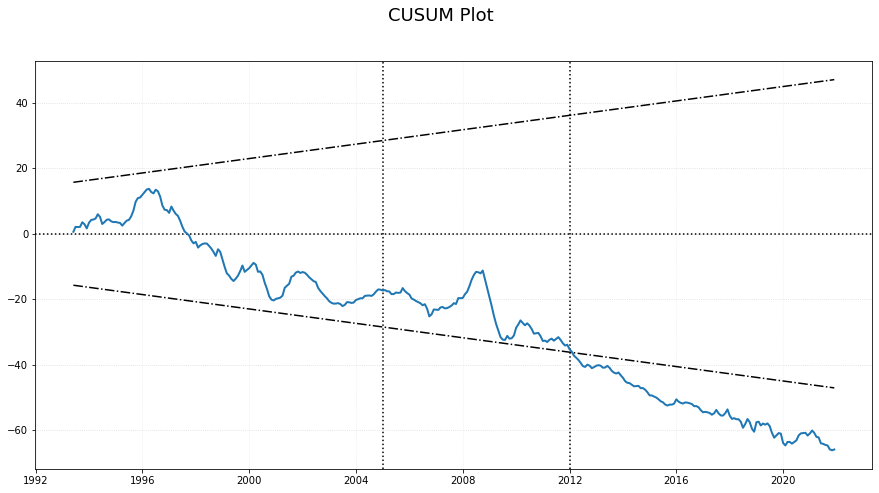

In [181]:
# CUSUM plot
plt.figure(figsize=(15,7.5))
plt.plot(pd.Series(recres[6][1],index=simdf.index[5:]),color='black', linestyle='-.')
plt.plot(pd.Series(recres[6][0],index=simdf.index[5:]),color='black', linestyle='-.')
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.axvline(x=pd.to_datetime('2012-01-01'), color='black', linestyle=':')
plt.plot(pd.Series(recres[5][1:],index=simdf.index[5:]), linewidth=2)
plt.suptitle('CUSUM Plot', fontsize=18)
plt.grid(axis='y', alpha=0.5, linestyle=':')
plt.grid(axis='x', alpha=0.25, linestyle=':')
plt.show()

Some evidence of structural break, but only after 2012. That is more likely to be due to the low inflation in the US after the 2008 recession.

Model 2: Seasonally adjusted data for pre IT period

In [37]:
# Pre IT Period
mod1_2 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6+ inf_seasAdj_l12', data=predf).fit()
print(mod1_2.params)
print('Estimated persistence, pre IT period: ', mod1_2.params.sum())


Intercept         -0.018508
inf_seasAdj_l1     0.601015
inf_seasAdj_l3    -0.326144
inf_seasAdj_l6     0.185841
inf_seasAdj_l12   -0.158810
dtype: float64
Estimated persistence, pre IT period:  0.28339313572024427


In [38]:
mod1_2.pvalues
# All lags significant

Intercept          7.202812e-01
inf_seasAdj_l1     1.660549e-16
inf_seasAdj_l3     6.798430e-08
inf_seasAdj_l6     3.750610e-03
inf_seasAdj_l12    3.598549e-04
dtype: float64

Model 3: Seasonally adjusted data for IT period


In [39]:
# IT Period
mod1_3 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6+ inf_seasAdj_l12', data=itdf).fit()
print(mod1_3.params)
print('Estimated persistence, IT period: ', mod1_3.params.sum())

Intercept         -0.029452
inf_seasAdj_l1     0.737347
inf_seasAdj_l3    -0.167511
inf_seasAdj_l6    -0.076055
inf_seasAdj_l12   -0.304669
dtype: float64
Estimated persistence, IT period:  0.15966046360458352


In [40]:
mod1_3.pvalues
# All lags significant

Intercept          4.082293e-01
inf_seasAdj_l1     2.102972e-32
inf_seasAdj_l3     5.356033e-04
inf_seasAdj_l6     1.092042e-01
inf_seasAdj_l12    1.357632e-08
dtype: float64

Persistence have decreased, with the introduction of the IT (lags significant in all models)

Model with whole period and Dummy for IT regime

as in Kontonikas (2004)

$\pi = \gamma_0 + (\gamma_1 + \gamma_5D_t)\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + (\gamma_4 + \gamma_6D_t)\pi_{t-12} + u_{1t}$


Model 2.1 Seasonally adjusted data

In [184]:
# Whole Period
mod2_1 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l1*target + inf_seasAdj_l12 + inf_seasAdj_l12*target', data=simdf).fit()
mod2_1.params

Intercept                -0.019269
inf_seasAdj_l1            0.952551
target                   -0.002557
inf_seasAdj_l1:target    -0.064079
inf_seasAdj_l12          -0.505887
inf_seasAdj_l12:target    0.039983
dtype: float64

In [149]:
mod2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            inf_seasAdj   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     91.14
Date:                Wed, 06 Jul 2022   Prob (F-statistic):           9.42e-61
Time:                        12:01:54   Log-Likelihood:                -329.71
No. Observations:                 348   AIC:                             671.4
Df Residuals:                     342   BIC:                             694.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0193      0.125     -0.154      0.878      -0.266       0.227
inf_seasAdj_l1             0.9526      0.166      5.740      0.000       0.626       1.279
target                    -0.0026      0.022     -0.115      0.908      -0.046       0.041
inf_seasAdj_l1:target     -0.0641      0.028     -2.313      0.021      -0.119      -0.010
inf_seasAdj_l12           -0.5059      0.161     -3.148      0.002      -0.822      -0.190
inf_seasAdj_l12:target     0.0400      0.025      1.594      0.112      -0.009       0.089
==============================================================================
Omnibus:                        9.064   Durbin-Watson:                   1.156
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               15.707
Skew:                           0.068   Prob(JB):                     0.000388
Kurtosis:                       4.032   Cond. No.                         45.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
mod2_1.params[3] + mod2_1.params[5]

# The sum is negative, means that IT has diminished the inflation 
# The interaction term with the 1st lag is negative and significant, means that IT has decreased the inflation persistance


-0.024096061067231

In [151]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
# recres2 = recursive_olsresiduals(mod2_1, alpha=0.90)

breaks_cusumolsresid(mod2_1.resid)
# We cannot reject the null hypothesis of no structural change.

(0.5971252248765686, 0.8680662708207081, [(1, 1.63), (5, 1.36), (10, 1.22)])

Model 2.1B Observed data

In [214]:
# Whole Period
mod2_1B = smf.ols(formula='v_cpi ~ l1 + l1*target + l12 + l12*target', data=simdf2).fit()
mod2_1B.params

Intercept    -0.876184
l1            1.011913
target        0.304443
l1:target    -0.009193
l12          -0.016962
l12:target   -0.010818
dtype: float64

In [215]:
mod2_1B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  v_cpi   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1262.
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          5.84e-218
Time:                        12:22:02   Log-Likelihood:                -383.70
No. Observations:                 348   AIC:                             779.4
Df Residuals:                     342   BIC:                             802.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8762      0.513     -1.708      0.089      -1.885       0.133
l1             1.0119      0.069     14.755      0.000       0.877       1.147
target         0.3044      0.109      2.803      0.005       0.091       0.518
l1:target     -0.0092      0.012     -0.786      0.432      -0.032       0.014
l12           -0.0170      0.062     -0.272      0.786      -0.140       0.106
l12:target    -0.0108      0.011     -1.001      0.317      -0.032       0.010
==============================================================================
Omnibus:                        7.637   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               11.553
Skew:                           0.107   Prob(JB):                      0.00310
Kurtosis:                       3.867   Cond. No.                         896.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [216]:
mod2_1B.params[3] + mod2_1B.params[5] 

# The sum is negative, means that IT has diminished the inflation 
# The interaction term with the 1st lag is negative and significant, means that IT has decreased the inflation persistance

-0.020010896983991076

In [220]:
# Probability of observing the data under the null hypothesis of no structural change,
#  based on asymptotic distribution which is a Brownian Bridge 
# recres2 = recursive_olsresiduals(mod2_1B, alpha=0.90)

breaks_cusumolsresid(mod2_1B.resid)
# We cannot reject the null hypothesis of no structural change.

(1.1983590957442602, 0.11313618670437997, [(1, 1.63), (5, 1.36), (10, 1.22)])

Chow Test

Perfom Chow Test to check structural break in 2005 due to the IT introduction

Test for seasonally adjusted data

In [152]:
# Chow test for inflation persistance using inflation lagged 1 period (one month) (SHORT RUN)
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l1'],
                    len(predf)-1, len(predf), 0.05)

# Fail to Reject -> Not enough evidence that IT has introduced a strutural change in the inflation persistance 

Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 1.8067814504302555, P_value: 0.16574076007097582


(1.8067814504302555, 0.16574076007097582)

In [153]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf['inf_seasAdj'], simdf['inf_seasAdj_l12'],
                    len(predf)-1, len(predf), 0.05)

# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 3.1536513493873057, P_value: 0.04393665669678393


(3.1536513493873057, 0.04393665669678393)

Tests for observed data

We can observe more evidence when using the observed data (which is stationary considering the longer period)

In [222]:
# Chow test for inflation persistance using inflation lagged 1 period (one month) (SHORT RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l1'],
                    len(predf2)-1, len(predf2), 0.05)

# Fail to Reject -> Not enough evidence that IT has introduced a strutural change in the inflation persistance 

Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.6299949420644463, P_value: 0.5332096227065113


(0.6299949420644463, 0.5332096227065113)

In [229]:
# Chow test for inflation persistance using inflation lagged 3 periods (one quarter) 
chow_test.chow_test(simdf2['v_cpi'], simdf2['l3'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance                    

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 3.790284618264656, P_value: 0.02354109765226342


(3.790284618264656, 0.02354109765226342)

In [235]:
# Chow test for inflation persistance using inflation lagged 6 periods (two quarters) 
chow_test.chow_test(simdf2['v_cpi'], simdf2['l6'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance    

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 11.239919003142624, P_value: 1.8700982123642795e-05


(11.239919003142624, 1.8700982123642795e-05)

In [228]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l12'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 34.3325482472182, P_value: 2.5646151868841116e-14


(34.3325482472182, 2.5646151868841116e-14)

In [236]:
# Chow test for inflation persistance using inflation lagged 12 periods (one year) (LONGER RUN)
chow_test.chow_test(simdf2['v_cpi'], simdf2['l24'],
                    len(predf2)-1, len(predf2), 0.05)
# Reject -> There is evidence that IT has introduced a strutural change in the inflation persistance

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 36.93981770062148, P_value: 2.9976021664879227e-15


(36.93981770062148, 2.9976021664879227e-15)